In [1]:
import copy
import warnings
import numpy as np 
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from numpy.random import choice
from scipy.cluster.hierarchy import linkage
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import dendrogram, linkage,to_tree
from collections import defaultdict
from scipy.cluster.hierarchy import ClusterNode
import warnings
warnings.filterwarnings('ignore')

In [2]:
import random

In [3]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [4]:
labelset, y_label = np.unique(y_pool, return_inverse=True)

In [36]:
labelset, test_label = np.unique(y_test, return_inverse=True)

In [5]:
mylinkage = linkage(X_pool,method="average")

In [138]:
class myHS(object):
    """
    Construct a Hierarchical sampling class.

    """
    def __init__(self, X ,y, mylikage):
        """
        Initialize the Hierarchical sampling.
        Given the training set X and its Label y, 
        return the all the implementation methods.

        X: Training Data, size n * d
        y: The label of the Training Data, size n
        """
        
        # Compute the Hierarchical tree for X
        #mylinkage = linkage(X,method="average")
        #print("Finish build likage..")
        # Build the Hierarchical Tree Structure
        self.rootnode,self.nodelist  = to_tree(mylinkage,rd = True)

        # Add Parent node to each node, earier for future implementation
        self.rootnode.parent = None
        for node in self.nodelist:
            if node.get_left():
                node.left.parent = node
            if node.get_right():
                node.right.parent = node


        # Record the number of class n
        self.n_labels = len(set(y))
        empty_matrix = np.zeros((len(self.nodelist),self.n_labels))


        ## Update Empirical count and probabilities

        # Record the number of point sampled from node V of each class
        self.label_count = empty_matrix.copy()
        # Record the fraction of label l in points sampled from Subtree V
        self.proba = empty_matrix.copy()
        # Record if the node is admissible or not

        self.n = np.zeros(len(self.nodelist))
        ## Update Admissible and Score
        self.admissible = empty_matrix.copy()
        # Record score for each node
        self.score = np.zeros(len(self.nodelist))


        ## Prune and assign Labels
        # Record if achieve score
        self.prune = empty_matrix.copy()
        # Record the labels
        self.label = empty_matrix.copy()


        # Record the Lower bound and Upper Bound
        self.UB = empty_matrix.copy()
        self.LB = empty_matrix.copy()


    def select(self,P,selection_type="Upper"):
        """
        Selection Function, use Active Sampling as selection crieria.
        Return a selected node.

        P: Current pruning of tree, size p * 1 (A list of node index)
        selection_type: A string, indicates use Upper bound or Lower
        bound as the selection criteria. Default is Upper.
        """

        # Choose use Upper Bound or use Lower Bound
        if selection_type == "Upper":
            bound = self.UB[P]
        else:
            bound = self.LB[P]
       
        bound = bound[np.arange(len(bound)),self.label[P].astype(int)]

        if np.sum(bound) == 0:
            return random.choices(P)[0]
        # The node count record the number of child nodes contains   in           each node, use as the weight parameter.
        weight = np.array([self.nodelist[node].count for node in P])
        probs = weight * (1-bound)

        return random.choices(P,weights = probs/sum(probs))[0]

        
    def leaves(self, node, leaf_list = None):
        """
        Get all the leaf node from a given node recursively. 
        Return a list of leaf node.

        node: Current root node
        leaf_list: A list used to store all the found leaf node.
        """
        # Get all the leaf node from the root, not child node, but leaf node
        node = self.nodelist[node]
        if not leaf_list:
            leaf_list = []
        if node.is_leaf():
            leaf_list.append(node)
            return leaf_list
        else:
            leaf_list = self.leaves(node.left.id,leaf_list)
            leaf_list = self.leaves(node.right.id,leaf_list)
            
            return leaf_list

    def rand_pick(self, node, queries, leaf_list = None):
        """
        Query node from the list of leaf node of the given subtree
        randomly. If a node has been queryed, then it will random
        select one node from the queries list.
        Return a selected node z

        node: Current root node
        queries: A list that record all queryed node
        leaf_list: A list used to store all the found leaf node.
        """

        
        leaves_list = self.leaves(node)
        leaves_id = np.array([leaf.id for leaf in leaves_list])
        queries = np.array(queries)

        not_query = np.setdiff1d(leaves_id,queries)
        if len(not_query) == 0:
            return self.nodelist[random.choice(queries)]
        else:
            return random.choice(leaves_list)

    def empirical_counts_proba(self, z, v, label):
        """
        Update the number of points queryed from node v and the
        fraction of label.

        z: Current node
        v: subroot node
        label: queryed z's label
        """
        if not isinstance(z,ClusterNode):
            z = self.nodelist[z]
        if not isinstance(v,ClusterNode):
            v = self.nodelist[v] 
 
        # make sure we are count all the leaf node under the subroot node v
        while z and z.id <= v.id:
 
            # Use Label count to record the label of each queryed node
            self.label_count[z.id][label]+=1
            # Record the number that the node has been counted
            self.n[z.id] +=1
            z = z.parent
     
        self.n = self.n.reshape((len(self.n), 1))      

        self.proba = self.label_count/self.n 


    def update_admissible(self,beta):
        delta = 1/self.n + np.sqrt(self.proba*(1-self.proba)/self.n)
        lower = np.fmax(self.proba-delta,0)
        upper = np.fmin(self.proba+delta,1)
        
        for l in np.arange(self.n_labels):
            upper_lp = np.delete(upper,l,axis = 1)
            self.admissible[:,l] = np.all((1-lower[:,l][:,None])<beta*(1-upper_lp),axis = 1)
        
        
        self.E_vl = 1-self.proba
        self.E_vl[~self.admissible] = 1
        
        self.UB = upper
        self.LB = lower
    
    def update_score(self):
        
        for i in range(len(self.nodelist)):
            current_node = self.nodelist[i]
            if current_node.is_leaf():
                self.score[i] = np.nanmin(self.E_vl[i])
                self.prune[i] = False
            else:
                
                if self.admissible[i,:].any():
                    
                    a_score = (current_node.left.count/current_node.count) * self.score[current_node.left.id]
                    b_score = (current_node.right.count/current_node.count) * self.score[current_node.right.id]
                    if a_score+b_score < np.nanmin(self.E_vl[i]):
                        self.score[i] = a_score+b_score
                        self.prune[i] = True
                    else:
                        self.score[i] = np.nanmin(self.E_vl[i])
                        
                        self.prune[i] = False
                else:
                    
                    self.score[i] = np.nanmin(self.E_vl[i])
                    self.prune[i] = False

    def recursively_update_label(self,node,P):

        
        if not isinstance(node, ClusterNode):
            node = self.nodelist[node]
        if not isinstance(P, ClusterNode):
            P = self.nodelist[P]

        if node.is_leaf():
            self.label[node.id] = self.label[P.id]
        else:
            self.recursively_update_label(node.left,P)
            self.recursively_update_label(node.right,P)

    def update_L_P(self,P):
        P_prime = []
        for i in P:
            node = self.nodelist[i]
            if self.prune[i]:

                label = np.where(self.admissible[i,:])[0][0]
                P_prime.append(node.left.id)
                P_prime.append(node.right.id)

                self.label[node.left.id] = label
                self.label[node.right.id] = label
            else:
                P_prime.append(i)
                self.label[node.id] = np.nanargmin(self.E_vl[i])
                
        for p in P_prime:
            self.recursively_update_label(p,p)
        return P_prime
        

In [136]:
def Cluster_adaptive_active_learning(X, y, max_size,beta,mylinkage):
    P_list = []
    labelset, y = np.unique(y, return_inverse=True)
    #X_linkage = linkage(X,method='average')
    Tree = myHS(X,y,mylinkage)
    P = np.array([Tree.rootnode.id])
    ######################
    queries = []
    while len(queries) < max_size:

        #v = Tree.select_LB(P)
        v = Tree.select(P)     
        z = Tree.rand_pick(v,queries)
        queries.append(z.id)
        label = y[z.id] 
            # print("sample node: ",z.id,"actual label: ",label)  
            # print()      
        Tree.empirical_counts_proba(z,v,label)
            #Tree.update_empirical(z,v,label)
        Tree.update_admissible(beta)
        Tree.update_score()
        #Tree.best_pruning_and_labeling(P)
        P = Tree.update_L_P(P)
        P_list.append(P)
    #print(P_list)
    return queries, P_list


In [139]:
UB_Query, UB_P = Cluster_adaptive_active_learning(X_pool,y_label,3000,2,mylinkage)

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [22]:
Query, P = Cluster_adaptive_active_learning(X_pool,y_label,3000,mylinkage)

Leaves: 9640, Queries: 0, Not query: 9640
Leaves: 9640, Queries: 1, Not query: 9639
Leaves: 9640, Queries: 2, Not query: 9638
Leaves: 9640, Queries: 3, Not query: 9637
Leaves: 9640, Queries: 4, Not query: 9636
Leaves: 9640, Queries: 5, Not query: 9635
Leaves: 9640, Queries: 6, Not query: 9634
Leaves: 9640, Queries: 7, Not query: 9633
Leaves: 9640, Queries: 8, Not query: 9632
Leaves: 9639, Queries: 9, Not query: 9630
Leaves: 9298, Queries: 10, Not query: 9289
Leaves: 9298, Queries: 11, Not query: 9288
Leaves: 9298, Queries: 12, Not query: 9287
Leaves: 9298, Queries: 13, Not query: 9286
Leaves: 9294, Queries: 14, Not query: 9281
Leaves: 9137, Queries: 15, Not query: 9123
Leaves: 9132, Queries: 16, Not query: 9117
Leaves: 9116, Queries: 17, Not query: 9100
Leaves: 9116, Queries: 18, Not query: 9099
Leaves: 9079, Queries: 19, Not query: 9061
Leaves: 9055, Queries: 20, Not query: 9036
Leaves: 9054, Queries: 21, Not query: 9034
Leaves: 9053, Queries: 22, Not query: 9032
Leaves: 9017, Queries

In [34]:
newQuery, newP = Cluster_adaptive_active_learning(X_pool,y_label,3000,mylinkage)

Leaves: 9640, Queries: 0, Not query: 9640
Leaves: 9640, Queries: 1, Not query: 9639
Leaves: 9640, Queries: 2, Not query: 9638
Leaves: 9640, Queries: 3, Not query: 9637
Leaves: 9640, Queries: 4, Not query: 9636
Leaves: 9640, Queries: 5, Not query: 9635
Leaves: 9640, Queries: 6, Not query: 9634
Leaves: 9640, Queries: 7, Not query: 9633
Leaves: 9640, Queries: 8, Not query: 9632
Leaves: 9639, Queries: 9, Not query: 9630
Leaves: 9298, Queries: 10, Not query: 9288
Leaves: 9294, Queries: 11, Not query: 9283
Leaves: 9137, Queries: 12, Not query: 9126
Leaves: 9137, Queries: 13, Not query: 9125
Leaves: 9137, Queries: 14, Not query: 9124
Leaves: 9137, Queries: 15, Not query: 9123
Leaves: 9137, Queries: 16, Not query: 9122
Leaves: 9137, Queries: 17, Not query: 9121
Leaves: 9137, Queries: 18, Not query: 9120
Leaves: 9137, Queries: 19, Not query: 9119
Leaves: 9137, Queries: 20, Not query: 9118
Leaves: 9137, Queries: 21, Not query: 9117
Leaves: 9132, Queries: 22, Not query: 9111
Leaves: 9116, Queries

In [35]:
len(newP[-1])

532

In [41]:
lr = LogisticRegression().fit(X_pool[newQuery],y_label[newQuery])

In [42]:
lr.score(X_test,test_label)

0.47883817427385894

In [43]:
lr1 = 

In [44]:
newscore_list = []
sample_list = []
for i in range(300,3000+60,60):
    index = newQuery[:i]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_label[index])
    newscore_list.append(lr.score(X_test[index],test_label[index]))

0.4721991701244813

In [97]:
UB_score_list = []
sample_list = []
for i in range(300,3000+60,60):
    index = UB_Query[:i]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_label[index])
    UB_score_list.append(lr.score(X_test[index],test_label[index]))

In [53]:
score_list = []
sample_list = []
for i in range(300,3000+60,60):
    index = Query[:i]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_label[index])
    score_list.append(lr.score(X_test[index],test_label[index]))

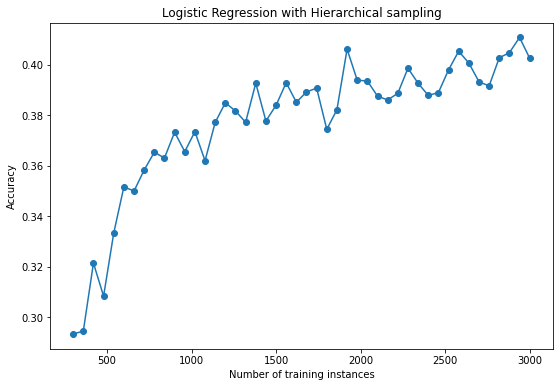

In [98]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(sample_list,UB_score_list,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Hierarchical sampling")


plt.show()

In [99]:
max(UB_score_list)

0.4108843537414966

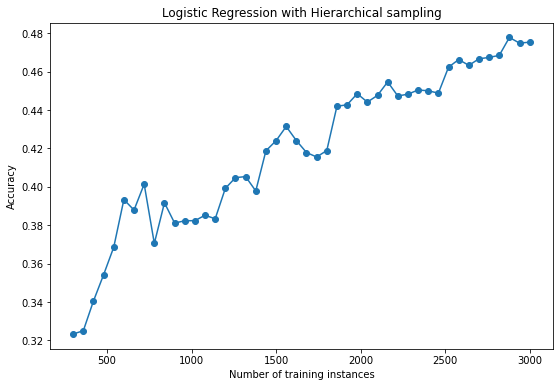

In [55]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(sample_list,score_list,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Hierarchical sampling")


plt.show()

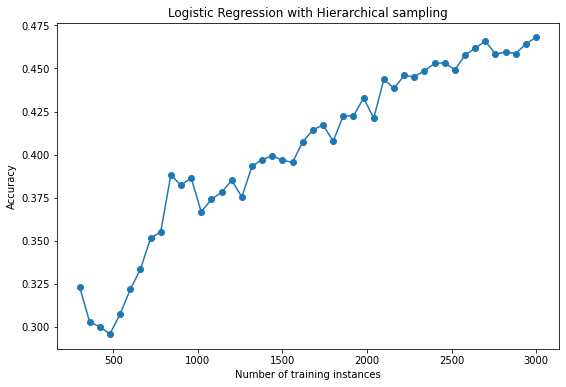

In [64]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(sample_list,newscore_list,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Hierarchical sampling")


plt.show()

In [45]:
initial = Query[:300]

In [120]:
class myHS(object):
    """
    Construct a Hierarchical sampling class.

    """
    def __init__(self, X ,y):
        """
        Initialize the Hierarchical sampling.
        Given the training set X and its Label y, 
        return the all the implementation methods.

        X: Training Data, size n * d
        y: The label of the Training Data, size n
        """
        
        # Compute the Hierarchical tree for X
        mylinkage = linkage(X,method="average")
        print("Finish build likage..")
        # Build the Hierarchical Tree Structure
        self.rootnode,self.nodelist  = to_tree(mylinkage,rd = True)

        # Add Parent node to each node, earier for future implementation
        self.rootnode.parent = None
        for node in self.nodelist:
            if node.get_left():
                node.left.parent = node
            if node.get_right():
                node.right.parent = node


        # Record the number of class n
        self.n_labels = len(set(y))
        empty_matrix = np.zeros((len(self.nodelist),self.n_labels))


        ## Update Empirical count and probabilities

        # Record the number of point sampled from node V of each class
        self.label_count = empty_matrix.copy()
        # Record the fraction of label l in points sampled from Subtree V
        self.proba = empty_matrix.copy()
        # Record if the node is admissible or not

        ## Update Admissible and Score
        self.admissible = empty_matrix.copy()
        # Record score for each node
        self.score = np.zeros(len(self.nodelist))


        ## Prune and assign Labels
        # Record if achieve score
        self.prune = empty_matrix.copy()
        # Record the labels
        self.label = empty_matrix.copy()


        # Record the Lower bound and Upper Bound
        self.UB = empty_matrix.copy()
        self.LB = empty_matrix.copy()


    def select(self,P,selection_type="Upper"):
        """
        Selection Function, use Active Sampling as selection crieria.
        Return a selected node.

        P: Current pruning of tree, size p * 1 (A list of node index)
        selection_type: A string, indicates use Upper bound or Lower
        bound as the selection criteria. Default is Upper.
        """

        # Choose use Upper Bound or use Lower Bound
        if selection_type == "Upper":
            bound = self.UB[P]
        else:
            bound = self.LB[P]

        print(bound)
        bound = bound[np.arange(len(bound)),self.label[P].astype(int)]
        # The node count record the number of child nodes contains   in           each node, use as the weight parameter.
        weight = np.array([self.nodelist[node].count for node in P])
        probs = weight * (1-bound)

        return random.choices(P,weights = probs/sum(probs))[0]

        
    def leaves(self, node, leaf_list = None):
        """
        Get all the leaf node from a given node recursively. 
        Return a list of leaf node.

        node: Current root node
        leaf_list: A list used to store all the found leaf node.
        """
        # Get all the leaf node from the root, not child node, but leaf node
        node = self.nodelist[node]
        if not leaf_list:
            leaf_list = []
        if node.is_leaf():
            leaf_list.append(node)
            return leaf_list
        else:
            leaf_list = self.leaves(node.left.id,leaf_list)
            leaf_list = self.leaves(node.right.id,leaf_list)
            
            return leaf_list

    def rand_pick(self, node, queries, leaf_list = None):
        """
        Query node from the list of leaf node of the given subtree
        randomly. If a node has been queryed, then it will random
        select one node from the queries list.
        Return a selected node z

        node: Current root node
        queries: A list that record all queryed node
        leaf_list: A list used to store all the found leaf node.
        """

        
        leaves_list = self.leaves(node)
        leaves_id = np.array([leaf.id for leaf in leaves_list])
        queries = np.array(queries)

        not_query = np.setdiff1d(leaves_id,queries)
        if len(not_query) == 0:
            return self.nodelist[random.choice(queries)]
        else:
            return random.choice(leaves_list)

    def empirical_counts_proba(self, z, v, label):
        """
        Update the number of points queryed from node v and the
        fraction of label.

        z: Current node
        v: subroot node
        label: queryed z's label
        """
        if not isinstance(z,ClusterNode):
            z = self.nodelist[z]
        if not isinstance(v,ClusterNode):
            v = self.nodelist[v] 
 
        # make sure we are count all the leaf node under the subroot node v
        while z and z.id <= v.id:
 
            # Use Label count to record the label of each queryed node
            self.label_count[z.id][label]+=1
            # Record the number that the node has been counted
            self.n[z.id] +=1
            z = z.parent
     
        #self.n = self.n.reshape((len(self.n), 1))      

        self.proba = self.label_count/self.n 


    def update_admissible(self,beta):
        delta = 1/self.n + np.sqrt(self.proba*(1-self.proba)/self.n)
        lower = np.fmax(self.proba-delta,0)
        upper = np.fmin(self.proba+delta,1)
        
        for l in np.arange(self.n_labels):
            upper_lp = np.delete(upper,l,axis = 1)
            self.admissible[:,l] = np.all((1-lower[:,l][:,None])<beta*(1-upper_lp),axis = 1)
        
        
        self.E_vl = 1-self.proba
        self.E_vl[~self.admissible] = 1
        
        self.UB = upper
        self.LB = lower
    
    def update_score(self):
        
        for i in range(len(self.nodelist)):
            current_node = self.nodelist[i]
            if current_node.is_leaf():
                self.score[i] = np.nanmin(self.E_vl[i])
                self.prune[i] = False
            else:
                
                if self.admissible[i,:].any():
                    
                    a_score = (current_node.left.count/current_node.count) * self.score[current_node.left.id]
                    b_score = (current_node.right.count/current_node.count) * self.score[current_node.right.id]
                    if a_score+b_score < np.nanmin(self.E_vl[i]):
                        self.score[i] = a_score+b_score
                        self.prune[i] = True
                    else:
                        self.score[i] = np.nanmin(self.E_vl[i])
                        
                        self.prune[i] = False
                else:
                    
                    self.score[i] = np.nanmin(self.E_vl[i])
                    self.prune[i] = False

    def recursively_update_label(self,node,P):

        
        if not isinstance(node, ClusterNode):
            node = self.nodelist[node]
        if not isinstance(P, ClusterNode):
            P = self.nodelist[P]

        if node.is_leaf():
            self.label[node.id] = self.label[P.id]
        else:
            self.recursively_update_label(node.left,P)
            self.recursively_update_label(node.right,P)

    def update_L_P(self,P):
        P_prime = []
        for i in P:
            node = self.nodelist[i]
            if self.prune[i]:

                label = np.where(self.admissible[i,:])[0][0]
                P_prime.append(node.left.id)
                P_prime.append(node.right.id)

                self.label[node.left.id] = label
                self.label[node.right.id] = label
            else:
                P_prime.append(i)
                self.label[node.id] = np.nanargmin(self.E_vl[i])
                
        for p in P_prime:
            self.recursively_update_label(p,p)
        return P_prime
        






In [ ]:
class myHS(object):
    def __init__(self, X,y,beta):
        
        # Compute the Hierarchical tree for X
        linkage = linkage(X,method="average")
        # Build the Hierarchical Tree Structure
        self.rootnode,self.nodelist  = to_tree(linkage,rd = True)

        # Record thenumber of class
        self.n_labels = len(set(y))
        # Record the number of nodes in the tree
        self.n_nodes = len(self.nodelist)

        # Add Parent node to each node, earier for future implementation
        self.rootnode.parent = None
        for node in self.nodelist:
            if node.get_left():
                node.left.parent = node
            if node.get_right():
                node.right.parent = node
   
        # Beta value(Admissble calculation)
        self.beta = beta

        # # Add parents to each node
        # self.complete_tree(self.rootnode, self.nodelist)
        
        empty_matrix = np.zeros((len(self.nodelist),self.n_labels))

        #the count of each class in points sampled from node.
        # Record the number of point sampled from node V of each class
        self.label_count = np.zeros((len(self.nodelist),self.n_labels))

        # Record the fraction of label l in points sampled from Subtree V
        self.proba = np.zeros((len(self.nodelist),self.n_labels))
           
        
        # # Record the number of 
        # self.n = np.zeros(self.n_nodes)

        # Record if the node is admissible or not
        #self.admissible = np.array(np.array([False]*len(self.nodelist)*self.n_labels).reshape(len(self.nodelist),self.n_labels))
        self.admissible = np.zeros((len(self.nodelist),self.n_labels))
        # Record score for each node
        self.score = np.zeros(len(self.nodelist))
        # Record if achieve score
        self.prune = np.zeros(len(self.nodelist))
        # Record the labels
        self.label = np.zeros(len(self.nodelist))


        # Record the Lower bound and Upper Bound
        self.UB = np.zeros((len(self.nodelist),self.n_labels))
        self.LB = np.zeros((len(self.nodelist),self.n_labels))

    def complete_tree(self,rootnode,nodelist):
        rootnode.parent = None
        for node in nodelist:
            if node.get_left():
                node.left.parent = node
            if node.get_right():
                node.right.parent = node
            node.sampled = 0
    
   
    def select(self,P):
        
        p_UB = self.UB[P]
        L = self.label[P].astype(int)
        w = np.array([self.nodelist[node].count for node in P])
        p_UB = p_UB[np.arange(len(p_UB)),L]

        count = w *(1-p_UB)

        return random.choices(P,weights = count/sum(count) )[0]


    def select_LB(self,P):
        
        p_LB = self.LB[P]
        L = self.label[P].astype(int)

        w = np.array([self.nodelist[node].count for node in P])

        p_LB = p_LB[np.arange(len(p_LB)),L]

        count = w *(1-p_LB)
        # if np.sum(prob) == 0:
        #     return choice(prunning)
        return random.choices(P,weights = count/sum(count) )[0]
    
    def leaves(self, node,leaf_list = None):
        # Get all the leaf node from the root, not child node, but leaf node
        node = self.nodelist[node]
        if not leaf_list:
            leaf_list = []
        if node.is_leaf():
            leaf_list.append(node)
            return leaf_list
        else:
            leaf_list = self.leaves(node.left.id,leaf_list)
            leaf_list = self.leaves(node.right.id,leaf_list)
            
            return leaf_list

    def rand_pick(self,node,queries,leaf_list=None):
        
        leaves_list = self.leaves(node)
        leaves_id = np.array([leaf.id for leaf in leaves_list])
        queries = np.array(queries)

        not_query = np.setdiff1d(leaves_id,queries)
        print(f"Leaves: {len(leaves_id)}, Queries: {len(queries)}, Not query: {len(not_query)}")
        if len(not_query) == 0:
            print("***Queries from queryed***")
            return self.nodelist[random.choice(queries)]
        else:
            return random.choice(leaves_list)

    def update_empirical_counts_proba(self,
                          current, 
                          v,
                          label):

        current = self.nodelist[current] if not isinstance(current,ClusterNode) else current
        v = self.nodelist[v] if not isinstance(v,ClusterNode) else v
 
        # make sure if 
        while current and current.id <= v.id:
 

            # n * label matrix, 记录每个node都被label成什么
            self.label_count[current.id][label]+=1
            # n 记录每个node被sample几次
            self.n[current.id] +=1
            current = current.parent
     
        self.n = self.n.reshape((len(self.n), 1))      

        self.proba = self.label_count/self.n 


    def update_admissible(self):
        delta = 1/self.n + np.sqrt(self.proba*(1-self.proba)/self.n)
        lower = np.fmax(self.proba-delta,0)
        upper = np.fmin(self.proba+delta,1)
        
        for l in np.arange(self.n_class):
            upper_lp = np.delete(upper,l,axis = 1)
            self.admissible[:,l] = np.all((1-lower[:,l][:,None])<self.beta*(1-upper_lp),axis = 1)
        
        
        self.E_vl = 1-self.proba
        self.E_vl[~self.admissible] = 1
        
        self.UB = upper
        self.LB = lower
    
    def update_score(self):
        
        for i in range(len(self.nodelist)):
            current_node = self.nodelist[i]
            if current_node.is_leaf():
                self.score[i] = np.nanmin(self.E_vl[i])
                self.prune[i] = False
            else:
                
                if self.admissible[i,:].any():
                    
                    a_score = (current_node.left.count/current_node.count) * self.score[current_node.left.id]
                    b_score = (current_node.right.count/current_node.count) * self.score[current_node.right.id]
                    if a_score+b_score < np.nanmin(self.E_vl[i]):
                        self.score[i] = a_score+b_score
                        self.prune[i] = True
                    else:
                        self.score[i] = np.nanmin(self.E_vl[i])
                        
                        self.prune[i] = False
                else:
                    
                    self.score[i] = np.nanmin(self.E_vl[i])
                    self.prune[i] = False

    def recursively_update_label(self,node,P):

        
        if not isinstance(node, ClusterNode):
            node = self.nodelist[node]
        if not isinstance(P, ClusterNode):
            P = self.nodelist[P]

        if node.is_leaf():
            self.label[node.id] = self.label[P.id]
        else:
            self.recursively_update_label(node.left,P)
            self.recursively_update_label(node.right,P)

    def update_L_P(self,P):
        P_prime = []
        for i in P:
            node = self.nodelist[i]
            if self.prune[i]:

                label = np.where(self.admissible[i,:])[0][0]
                P_prime.append(node.left.id)
                P_prime.append(node.right.id)

                self.label[node.left.id] = label
                self.label[node.right.id] = label
            else:
                P_prime.append(i)
                self.label[node.id] = np.nanargmin(self.E_vl[i])
                
        for p in P_prime:
            self.recursively_update_label(p,p)
        return P_prime
        


In [100]:
"""
Created on Mon Mar  1 22:42:04 2021

@author: Haotian Teng
"""
import numpy as np
from numpy.random import choice
from typing import List, Tuple, Union, Iterable
from scipy.cluster.hierarchy import to_tree
from scipy.cluster.hierarchy import ClusterNode
class HierarchicalSampling(object):
    def __init__(self,linkage:np.ndarray, n_samples:int, n_class:int):
        """
        Implmentation of Hierarchical Sampling for Active Learning:
        https://icml.cc/Conferences/2008/papers/324.pdf

        Parameters
        ----------
        linkage : np.ndarray
            A linkage matrix from scipy.cluster.hierarchy.linkage.
        n_samples : int
            Number of samples.
        n_class : int
            Number of classes.

        Returns
        -------
        An instance for hierarchical sampling method.

        """
        self.n_samples = n_samples
        self.n_class = n_class
        self.btree, self.node_list = self._construct_btree(linkage)
        self.lc = np.array([x.count for x in self.node_list],dtype = np.int)
        self.n_nodes = len(self.node_list)
        self.major_label = np.zeros(self.n_nodes,dtype = np.int)
        self.c = np.zeros((self.n_nodes,n_class)) 
        #the count of each class in points sampled from node.
        self.p = np.zeros((self.n_nodes,n_class))
        #the fraction of each class in points sampled from node.
        self.sampled = np.zeros(self.n_nodes)
        #the number of points sampled in the subtree rooted at each node.
        self.A = np.zeros((self.n_nodes,n_class),dtype = bool)
        #the admmisible score of node i and label l.
        self.p_UB = np.zeros((self.n_nodes,n_class))
        #the lower bound of the probability for node i and label l.
    def _construct_btree(self,linkage):
        btree, node_list = to_tree(linkage,rd = True)
        btree.parent = None
        for node in node_list:
            if node.left:
                node.left.parent = node 
            if node.right:
                node.right.parent = node
            node.sampled = 0
            if node.is_leaf():
                node.queryed = False
        return btree, node_list
    
    @property
    def leaves_count(self):
        return self.lc
    
    def get_leaves(self, node:Union[ClusterNode,int],leaves:List[ClusterNode] = None)-> List:
        """
        Get the list of leaves node under the subtree.

        Parameters
        ----------
        node : Union[ClusterNode,int]
            The root node of the subtree.

        Returns
        -------
        List
            A list contain the leaves nodes.

        """
        node = self.node_list[node] if not isinstance(node,ClusterNode) else node
        if not leaves:
            leaves = []
        if node.is_leaf():
            leaves.append(node)
            return leaves
        else:
            leaves = self.get_leaves(node.left,leaves)
            leaves = self.get_leaves(node.right,leaves)
            return leaves
            
    def update_empirical(self,
                          current:Union[ClusterNode,int], 
                          subroot:Union[ClusterNode,int],
                          label:int):
        """
        Update empricial count for a given label from current node u to a
        subtree root node v.

        Parameters
        ----------
        current : Union[ClusterNode,int]
            The leaf node whose label gut queryed.
        subroot : Union[ClusterNode,int]
            The root node of the subtree pruning.
        label : int
            The label of current node.

        Returns
        -------
        None.

        """
        current = self.node_list[current] if not isinstance(current,ClusterNode) else current
        subroot = self.node_list[subroot] if not isinstance(subroot,ClusterNode) else subroot
        if not current.queryed:
            current.queryed = True
        while current and current.id <= subroot.id:
            self.c[current.id][label]+=1
            self.sampled[current.id] +=1
            current = current.parent
        self.p = self.c/self.sampled[:,None]
    
    def update_admissible(self,beta:float = 2.0):
        """
        Update the admissible score and the upper and lower bound.

        Parameters
        ----------
        beta : float, optional
            The hyperparameter beta, larger the beta, higher chance to expand
            more subtree along the tree. The default is 2.

        Returns
        -------
        None.

        """
        delta = 1/self.sampled[:,None]+np.sqrt(self.p*(1-self.p)/self.sampled[:,None])
        p_LB = np.fmax(self.p-delta,0)
        p_UB = np.fmin(self.p+delta,1)
        for l in np.arange(self.n_class):
            po_UB = np.delete(p_UB,l,axis = 1)
            self.A[:,l] = np.all(p_LB[:,l][:,None]>beta*po_UB-beta+1,axis = 1)
            # self.A[:,l] = p_LB[:,l]>1/3 #For 2 classes case.
        e_tilde = 1-self.p
        e_tilde[~self.A] = 1
        self.e_tilde = e_tilde
        self.p_UB = p_UB
    
    def best_pruning_and_labeling(self,
                                  prunning:Iterable[Union[ClusterNode,int]],
                                  beta:float = 2.0
                                  )-> Tuple[np.ndarray,int]:
        """
        Update admissible A and find the best prunning and the label for the 
        give non-leaf node.

        Parameters
        ----------
        prunning : Iterable[Union[ClusterNode,int]]
            The list of root of the selected subtree, the current "prunning".

        Returns
        -------
        prunning_ : numpy.ndarray
            A array given the best prunning node(s) given the subroot.
        label : int
            The major label of given subroot.

        """
        e_tilde = self.e_tilde
        prunning = [x.id if isinstance(x,ClusterNode) else x for x in prunning]
        score = np.zeros(len(self.node_list))
        new_prunnings = []
        for idx, node in enumerate(self.node_list):
            if node.is_leaf():
                score[idx] = np.nanmin(e_tilde[idx])
            else:
                score_curr = np.nanmin(e_tilde[idx])
                if np.any(self.A[idx,:]):
                    left = node.left
                    right = node.right
                    score_desc = left.count/node.count * score[left.id]+\
                                 right.count/node.count * score[right.id]
                    score[idx] = np.minimum(score_desc,score_curr)
                else:
                    score_desc = np.inf
                    score[idx] = score_curr
            if idx in prunning:
                if node.is_leaf():
                    label = np.nanargmin(e_tilde[idx])
                    prunning_ = [idx]
                else:
                    label = np.nanargmin(e_tilde[idx]) if score_curr<score_desc else np.where(self.A[idx,:])[0][0]
                    prunning_ = [idx] if score_curr<score_desc else [node.left.id,node.right.id]
                for p in prunning_:
                    self.major_label[p] = label
                new_prunnings.extend(prunning_)
        return new_prunnings
    
    def assign_labels(self, 
                       current:Union[ClusterNode,int], 
                       subroot:Union[ClusterNode,int]):
        """
        Assign label to the current node according to the root of subtree.

        Parameters
        ----------
        current : Union[ClusterNode,int]
            The node assign labels begins at.
        subroot : Union[ClusterNode,int]
            The root of the subtree node.

        Returns
        -------
        None.

        """
        subroot = self.node_list[subroot] if not isinstance(subroot, ClusterNode) else subroot
        current = self.node_list[current] if not isinstance(current, ClusterNode) else current
        if current.is_leaf():
            self.major_label[current.id] = self.major_label[subroot.id]
        else:
            self.assign_labels(current.left,subroot)
            self.assign_labels(current.right,subroot)
            
    def active_sampling(self,prunning:List[int])->int:
        """
        Active sampling of query prunning.

        Parameters
        ----------
        prunning : List[int]
            The current prunning of the tree.

        Returns
        -------
        int
            The node of prunning need to explore.

        """
        p_LB = self.p_UB[prunning]
        w = self.leaves_count[prunning]
        L = self.major_label[prunning]
        p_LB = p_LB[np.arange(len(p_LB)),L]
        prob = w*(1-p_LB)
        if np.sum(prob) == 0:
            return choice(prunning)
        prob = prob/prob.sum()
        return choice(prunning,p = prob)

In [101]:
def Cluster_adaptive(X,y,max_size,mylinkage):
    P_list = []
    Tree = HierarchicalSampling(mylinkage,9640,30)
    P = np.array([Tree.btree.id])
    ######################
    queries = []
    while len(queries) < max_size:
        print(len(queries))

        v = Tree.active_sampling(P)
        leaves = Tree.get_leaves(v)
        leaf = np.random.choice(leaves)

        queries.append(leaf)
        label = y[leaf.id]
        Tree.update_empirical(leaf,v,label)
        Tree.update_admissible()
        P = Tree.best_pruning_and_labeling(P)
        for p in P:
            Tree.assign_labels(p, p)
        P_list.append(P)
    return queries, P_list

In [102]:
gQuery_UB, gP_UB = Cluster_adaptive(X_pool,y_label,3000,mylinkage)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
Gscore_list = []
sample_list = []
for i in range(300,3000+60,60):
    index = [ node.id for node in gQuery[:i]]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_label[index])
    Gscore_list.append(lr.score(X_test[index],test_label[index]))

In [103]:
Gscore_list_UB = []
sample_list = []
for i in range(300,3000+60,60):
    index = [ node.id for node in gQuery_UB[:i]]
    sample_list.append(len(index))
    lr = LogisticRegression().fit(X_pool[index],y_label[index])
    Gscore_list_UB.append(lr.score(X_test[index],test_label[index]))

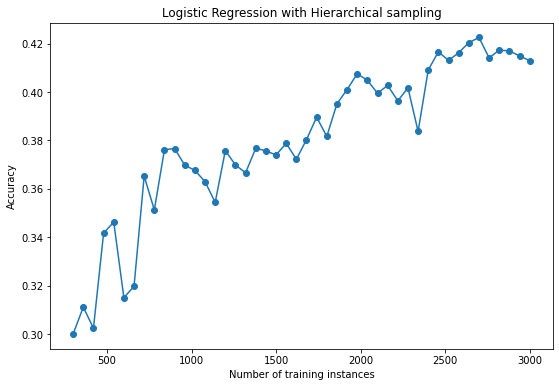

In [104]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(sample_list,Gscore_list_UB,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Hierarchical sampling")


plt.show()

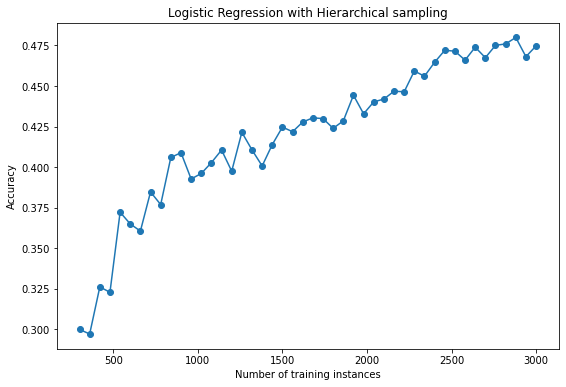

In [83]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

ax.plot(sample_list,Gscore_list,"o-")

ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of training instances')
plt.title("Logistic Regression with Hierarchical sampling")


plt.show()

In [84]:
max(Gscore_list)

0.4798611111111111